Imports

In [120]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torch.nn as F
import torchvision.transforms as transforms
import numpy as np

print(torch.version.cuda)

12.1


Set device

In [121]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# CIFAR 10 Dataset

### Import CIFAR 10 dataset

In [122]:
batch_size = 64

train_dataset = datasets.CIFAR10(root = './data',
                               train = True,
                               transform = transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std = (0.3105,))]),
                               download = True
                               )

test_dataset = datasets.CIFAR10(root='./data',
                               train=False,
                               transform=transforms.Compose([
                                   transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std=(0.3105,))]),
                               download=True
                               )
        
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Set up the LeNet ANN

In [123]:
class LeNet_mod(F.Module):
    def __init__(self, num_classes):
        super(LeNet_mod, self).__init__()
        self.layer1 = F.Sequential(
            F.Conv2d(3, 13, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(13),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = F.Sequential(
            F.Conv2d(13, 60, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(60),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = F.Linear(1500,360)
        self.relu = F.ReLU()
        self.fc1 = F.Linear(360,256)
        self.relu1 = F.ReLU()
        self.fc2 = F.Linear(256,num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### Epoch tests

##### Set Hyperparamaters

In [124]:
num_classes = 10
learning_rate = 0.001
num_epochs = 20

##### Using the NN

In [125]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

error = []

##### run NN. Record accuracy at the end

In [126]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        error.append(100 * correct / total)
        

##### Graph

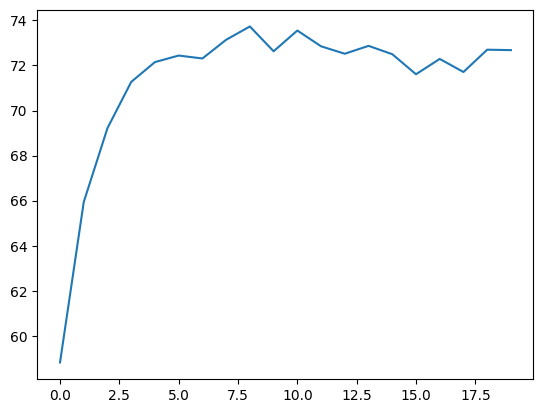

In [127]:
plt.plot(error)
plt.show()

In [128]:
print("Maximum accuracy of the network on the 10000 test images: {} at epoch {}".format(np.max(error), np.argmax(error)))

Maximum accuracy of the network on the 10000 test images: 73.73 at epoch 8


### Optimal Learning Rate

##### Hyperparameters

In [129]:
batch_size = 64
num_classes = 10
learning_rate = [1,0.1,0.01,0.001,0.0001,0.00001]
num_epochs = 7
error = []

##### Run the NN.
Record the loss at the end of each iteration

In [130]:
for i in learning_rate:    
    model = LeNet_mod(num_classes = num_classes).to(device)
    
    cost = F.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=i)
    
    total_step = len(train_loader)
    error.append([])
    for epoch in range(num_epochs):
        
        for j, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            error[-1].append(loss.item())

##### Graphs
Removed the first 1000 cases because the first epoch created an outlier.


There is an additional graph because the learning rates of 1 and 0.1 threw the scale of the graph off.

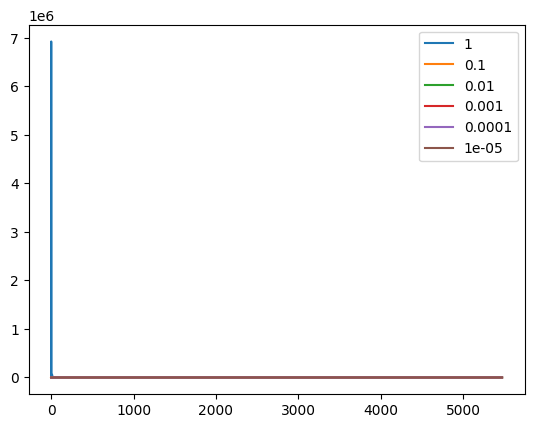

In [131]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

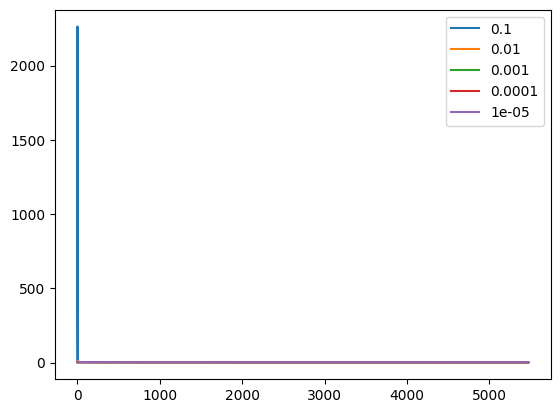

In [132]:
for i in range(1,len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

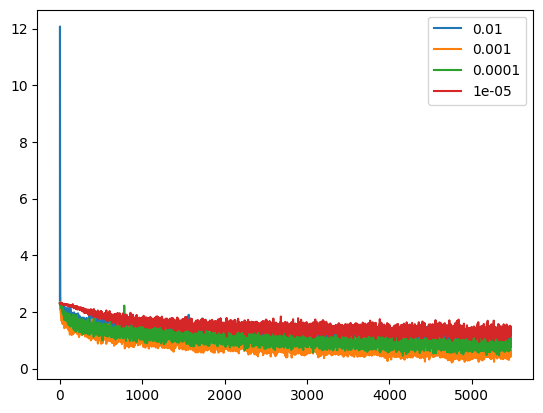

In [133]:
for i in range(2,len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

All individual graphs

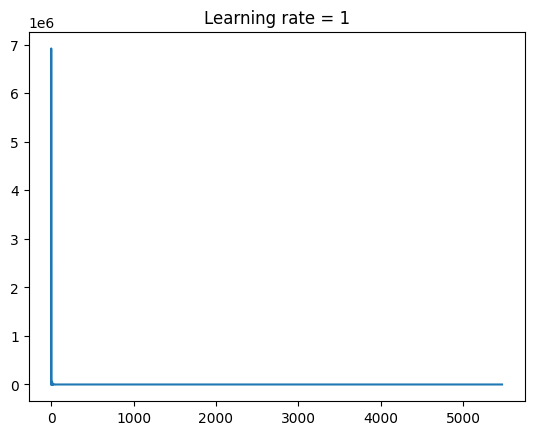

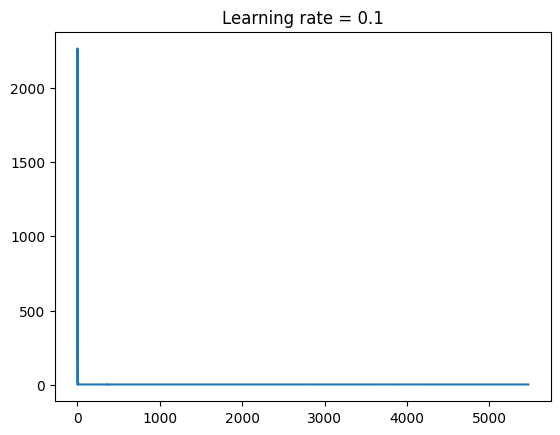

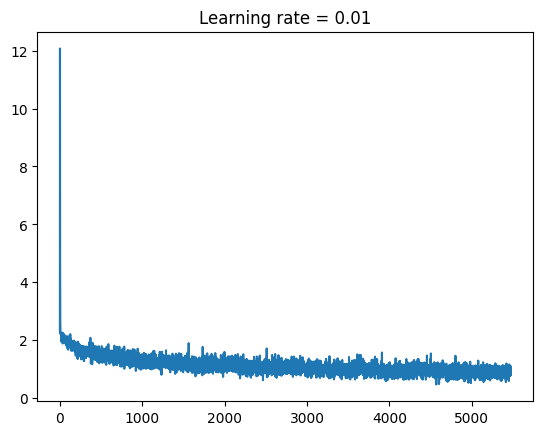

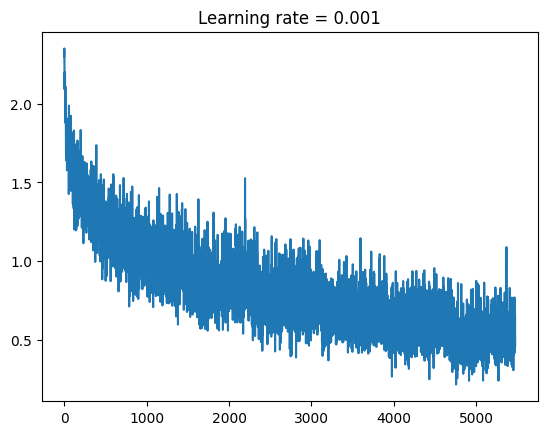

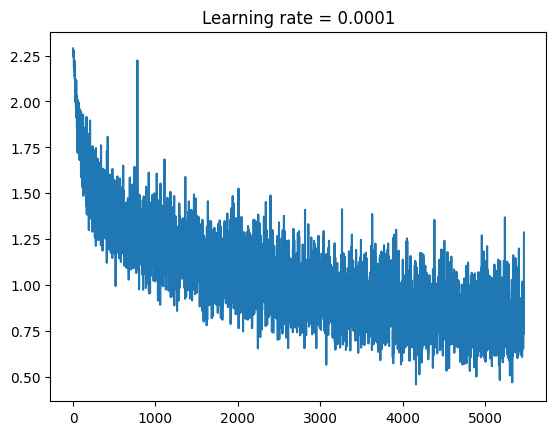

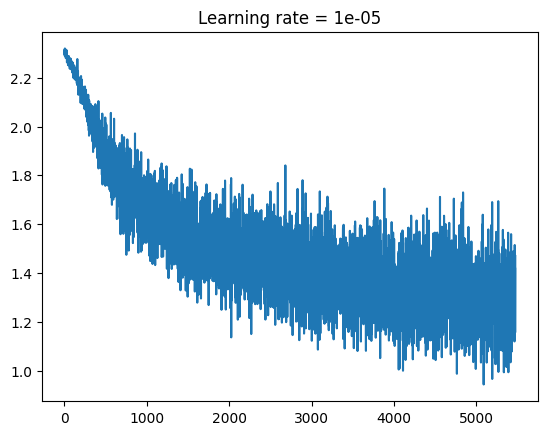

In [134]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
    plt.title('Learning rate = {}'.format(learning_rate[i]))
    plt.show()